In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline
import time


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import momentum_states_partition, pdf, fock_sector_budget


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)

In [2]:
def get_eigenstates(resolutions, g, mf, mb, Q, num_eigenstates, n_particles: int = None, verbose: bool = False):
    eigenvalues = []
    eigenstates = []

    initial_time = time.time()
    for res in resolutions:
        print("---K = ", res, "---")
        res_time_init = time.time()
        # hamiltonian = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
        hamiltonian = yukawa_hamiltonian(res = res, g = g, mf = mf, mb = mb, verbose = verbose)
        print("Size of Hamiltonian:", len(hamiltonian))
        print("Hamiltonian generation:", time.time() - res_time_init)
        res_time_init = time.time()
        res_tmp_basis = momentum_states_partition(res, n_particles = n_particles)
        print("Basis generation:", time.time() - res_time_init)
        res_time_init = time.time()
        baryon_number_basis = impose_baryon_number(res, res_tmp_basis, baryon_number=Q)
        res_time_init = time.time()
        print("Size of Q+cutoff basis:", len(baryon_number_basis))
        
        print("Matrix generation...")
        # tmp_mat = generate_matrix(hamiltonian, cutoff_basis)
        tmp_mat = generate_matrix_hermitian(hamiltonian, baryon_number_basis)
        print("Matrix generation:",  time.time() - res_time_init)
        res_time_init = time.time()


        # tmp_mat = generate_matrix(hamiltonian, baryon_number_basis)
        if tmp_mat.shape != (0, 0):
            print("Calculating eigenvalues...")
            vals, vecs = np.linalg.eigh(tmp_mat)
            print("Eigenvalues:", time.time() - res_time_init)
            vals = sorted(vals)
        # eigenvalues.append(vals[:num_eigenstates])
        # for i in range(0, num_eigenstates):
        #     eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))

        if num_eigenstates != 'all':
            eigenvalues.append(vals[:num_eigenstates])
            for i in range(0, num_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        else: 
            number_of_eigenstates = len(baryon_number_basis)
            eigenvalues.append(vals[:number_of_eigenstates])
            for i in range(0, number_of_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
            
        
    
    K_values = np.arange(1, len(eigenvalues) + 1)
    max_eigenvalues = max(len(eig) for eig in eigenvalues)

    padded_eigenvalues = np.array([
        np.pad(eig, (0, max_eigenvalues - len(eig)), constant_values=np.nan)
        for eig in eigenvalues
    ])

    padded_eigenvalues = padded_eigenvalues.T

    return padded_eigenvalues, eigenstates

In [31]:
max_res = 7
mf = 1
mb = 0.4
g = 1
Q = 0
n_particles = 4
num_eigenstates = 'all'
resolutions = [max_res]
# resolutions = np.arange(2, max_res, 1)

eigenvalues, eigenvectors = get_eigenstates(resolutions, g = g, mf = mf, mb = mb, Q = Q, num_eigenstates = num_eigenstates, n_particles = n_particles)

---K =  7 ---
Size of Hamiltonian: 1291
Hamiltonian generation: 6.403326988220215
Basis generation: 0.0015838146209716797
Size of Q+cutoff basis: 69
Matrix generation...
Matrix generation: 2.603336811065674
Calculating eigenvalues...
Eigenvalues: 0.0007860660552978516


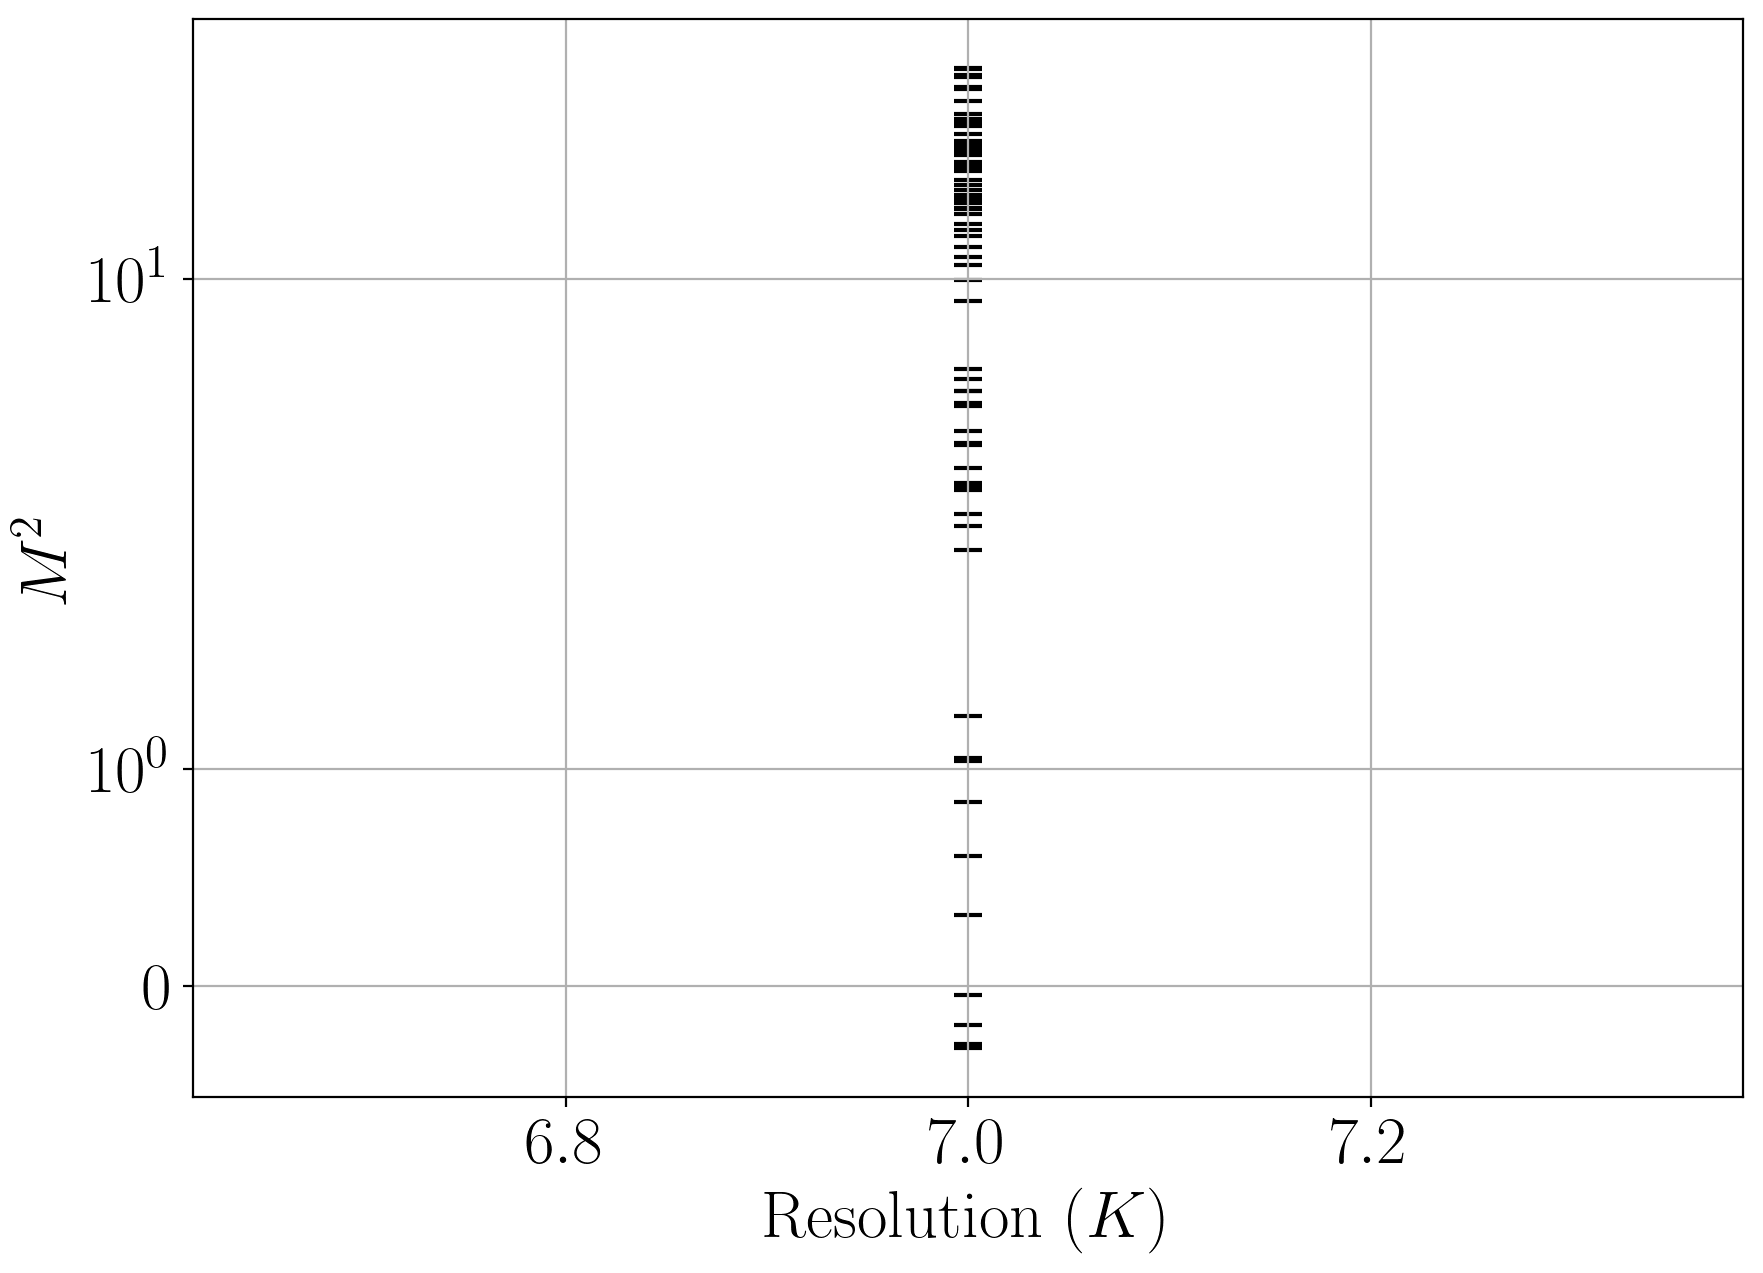

In [32]:
plt.figure(figsize = (10, 7), dpi = 200)
# K_values = range(1, max_res + 1)
colors = plt.cm.viridis(np.linspace(0, 1, eigenvalues.shape[0]))
for i, eig in enumerate(eigenvalues):
    # plt.plot(K_values, eig, color = colors[i], marker='o', label=f" $E_{i}$")#, label=f" $E_{i}$")#colors = colors[i]
    plt.scatter(resolutions, eig, color = 'black', marker = '_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M^2$")
# plt.title( f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
# plt.legend()
plt.yscale('symlog')
plt.grid()
plt.savefig("../bare_spectrum.pdf", dpi=300)

In [ ]:
psi = eigenvectors[0]
res = max_res

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (10, 7), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = r'$f+ \bar{f}$')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'b')


# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

In [ ]:
def m2_vs_res(res_vals, baryon_number, coupling = 1, mf = 1, mb = 1, eigenstate = 0):


    evals = []
    # K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in res_vals:
        ham = yukawa_Hamiltonian(res = res, g = coupling, mf=mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)
        # cutoff_states = impose_fock_sector_cutoff(baryon_number_basis, n_particles)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)
            evals.append(sorted(vals)[eigenstate])
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, eigenstate], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            # print(res, max_weight *  state, sorted(vals)[eigenstate])
            print(res, psi, sorted(vals)[eigenstate])

    return evals


In [ ]:
res = 6
g = 1
mf = 1
mb = 0.1
n_particles = 10
# kvals = [2**p for p in range(1, res)]
kvals = list(range(3, res + 1))
plt.figure(figsize = (4, 4), dpi = 200)
e = m2_vs_res(res_vals=kvals, baryon_number = 0, coupling = g, mf = mf, mb = mb, eigenstate = 6)
plt.scatter(kvals, np.array(e), marker='.')
# plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel('Resolution ($K$)')
plt.ylabel(f'$M^2$')
plt.title( f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.tight_layout()
# plt.legend()
plt.show()


In [ ]:
resolution = 3

mf = 1
mb = 0.1
K_tmp_basis = momentum_states_partition(res)
baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=0)

m2 = []
for coupling in range(0, 5):
    ham = yukawa_Hamiltonian(res = resolution, g = coupling, mf=mf, mb = mb)
    tmp_mat = generate_matrix(ham, baryon_number_basis)
    m2.append(min(np.linalg.eigvalsh(tmp_mat)))
plt.scatter(np.arange(0, 5, 1), m2, label = f'Res. = {resolution}')
plt.xlabel(f'$g$')
plt.ylabel(
    f'$M^2$'
)
plt.legend()

### Partition $H$ into blocks of definite $P^+$

In [ ]:
res = 2
min_res = res
g = 1
mf = 1
mb = 0.1

t = 0.1
treg = 0.01

basis = [momentum_states_partition(i)[j] for i in range(min_res, res + 1) for j in range(len(momentum_states_partition(i)))]
matrix = np.real(
        generate_matrix(yukawa_Hamiltonian(res, g = g, mf = mf, mb = mb), basis)
    )
# matrix = np.real(
#         generate_matrix(renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb), basis)
#     )
plt.imshow(
    matrix,
    cmap = 'Blues',
)
n_states_i = 0
for i in range(min_res, res + 1):
    n_states_i += len(momentum_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)
plt.colorbar()
plt.title(f'Yukawa Hamiltonian at $L = {2 * res}\pi$')

In [ ]:
res = 7
g = 1
mf = 1
mb = 0.1
baryon_number = 0
eigenstate = 1

ham = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)
psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (4, 4), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = f'Fermion $+$ Antifermion')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'Boson')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.xscale('log')
plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

## New $\mathcal{O}(g^2)$ Diagrams

In [ ]:
def renormalized_m2_vs_res(res_vals, t, treg, g, mf, mb, baryon_number):


    evals = []
    # K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in res_vals:
        ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)

            evals.append(min(vals))
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, 0], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            print(res, max_weight *  state, min(vals))
            # print(res, psi, min(vals))

    return evals


In [ ]:
res = 5
t = 0.1
treg = 0
mf = 1
mb = 0.1
g = 1

kvals = list(range(1, res + 1))
plt.figure(figsize = (4, 4), dpi = 200)
e = renormalized_m2_vs_res(res_vals=kvals, t = t, treg = treg, g = g, mf = mf, mb = mb, baryon_number=0)
plt.scatter(kvals, np.array(e), marker='.', label = 'Q = 0')
plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel('Res.')
plt.ylabel(f'$M^2$')
plt.tight_layout()
plt.legend()

plt.show()

In [ ]:
res = 5
mb = 0.1
g = 0.1
fig, ax = plt.subplots()
reses = [1, 2, 3, 4, 5]

for t in [0.001, 0.01, 0.1]:
    ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = 0, g = g, mf = 1, mb = mb)
    e = renormalized_m2_vs_res(res_vals=reses, t = t, treg = treg, g = g, mf = mf, mb = mb, baryon_number=0)
    L = 2*np.pi * res
        # mus = []
        # ks = []
    # for term, coeff in ham.op_dict.items():
    #     if 2 in [t[0] for t in term] and len(term) == 2:
    #         mode = term[0][1]
    #         k = mode + 1
    #         mu = coeff * p(k, L)
    #         ks.append(k)
    #         mus.append(mu)


    ax.plot(reses, np.array(e) - mb**2, ls = "", label = f'$t = {t}$', marker="o")

# ax.axhline(y=mb**2, color="black", alpha = 1, linewidth = 1)

# ax.axhline(y=e, color="black", alpha = 1, linewidth = 1)


# yticks = [0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
# yticklabels = [0, f'$M^2, \mu^2_0$', 0.02,  0.04, 0.06, 0.08, 0.1]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# ax.set_xticks(ks)


plt.ylabel(f'$M^2 - \mu_0^2$')
plt.xlabel('$K$')
plt.title(f'$g = {g}$')
plt.xticks(reses)

plt.legend()
plt.show()

In [ ]:
res = 6
t = 0.1
treg = 0
mf = 1
mb = 0.1
g = 0.1
baryon_number = 0


ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)



In [ ]:
eigenstate = 4

psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)


fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (10, 7), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = r'$f+ \bar{f}$')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'b')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

In [3]:
def get_renormalized_eigenstates(resolutions, t,  g, mf, mb, Q, num_eigenstates, n_particles: int = None, verbose:bool = False):
    eigenvalues = []
    eigenstates = []

    initial_time = time.time()
    for res in resolutions:
        print("---K = ", res, "---")
        res_time_init = time.time()
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = g, mf = mf, mb = mb, verbose = verbose)
        # hamiltonian += 57.42051673105974 * ParticleOperator('b0^ b0 d0^ d0')
        print("Size of Hamiltonian:", len(hamiltonian))
        print("Hamiltonian generated in:", time.time() - res_time_init)
        res_time_init = time.time()
        res_tmp_basis = momentum_states_partition(res, n_particles = n_particles)
        print("Basis generated in:", time.time() - res_time_init)
        res_time_init = time.time()
        baryon_number_basis = impose_baryon_number(res, res_tmp_basis, baryon_number=Q)
        res_time_init = time.time()
        
        print("Generating", len(baryon_number_basis), "x", len(baryon_number_basis), "Matrix...")
        # tmp_mat = generate_matrix(hamiltonian, cutoff_basis)
        tmp_mat = generate_matrix_hermitian(hamiltonian, baryon_number_basis)
        print("Matrix generated in:",  time.time() - res_time_init)
        res_time_init = time.time()


        # tmp_mat = generate_matrix(hamiltonian, baryon_number_basis)
        if tmp_mat.shape != (0, 0):
            print("Calculating eigenvalues...")
            vals, vecs = np.linalg.eigh(tmp_mat)
            print("Eigenvalues calculated in:", time.time() - res_time_init)
            vals = sorted(vals)

        if num_eigenstates != 'all':
            eigenvalues.append(vals[:num_eigenstates])
            for i in range(0, num_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        else: 
            number_of_eigenstates = len(baryon_number_basis)
            eigenvalues.append(vals[:number_of_eigenstates])
            for i in range(0, number_of_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        
    
    max_eigenvalues = max(len(eig) for eig in eigenvalues)

    padded_eigenvalues = np.array([
        np.pad(eig, (0, max_eigenvalues - len(eig)), constant_values=np.nan)
        for eig in eigenvalues
    ])

    padded_eigenvalues = padded_eigenvalues.T
    # assert all(padded_eigenvalues > 0)
    return padded_eigenvalues, eigenstates

In [115]:
max_res = 7
mf = 1
mb = 0.4
g = 1
t = 0.1
Q = 0
n_particles = 4
num_eigenstates = 'all'
resolutions = [max_res]
# ts = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ts = np.concatenate(([0], np.logspace(-15, 1, num=10)))

eigs = []
for t in ts:
    print("***** t = ", t, "*****")
    if t == 0:
        vals = get_eigenstates(resolutions, g = g, mf = mf, mb = mb, Q = Q, num_eigenstates = num_eigenstates,
                                n_particles = n_particles)[0]
    else:
        vals = get_renormalized_eigenstates(resolutions, t = t, g = g, mf = mf, 
            mb = mb, Q = Q, num_eigenstates = num_eigenstates, n_particles = n_particles)[0]
    eigs.append(vals)
shaped_eigs = np.hstack(eigs)


***** t =  0.0 *****
---K =  7 ---
Size of Hamiltonian: 1291
Hamiltonian generation: 6.538989067077637
Basis generation: 0.00152587890625
Size of Q+cutoff basis: 69
Matrix generation...
Matrix generation: 2.627127170562744
Calculating eigenvalues...
Eigenvalues: 0.004520893096923828
***** t =  1e-15 *****
---K =  7 ---


/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, 1, args=(t, p, mf, mb))[0]
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

Size of Hamiltonian: 1293
Hamiltonian generated in: 29.64185667037964
Basis generated in: 0.0014100074768066406
Generating 69 x 69 Matrix...
Matrix generated in: 2.6210920810699463
Calculating eigenvalues...
Eigenvalues calculated in: 0.0007479190826416016
***** t =  5.994842503189421e-14 *****
---K =  7 ---


/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, 1, args=(t, p, mf, mb))[0]
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

Size of Hamiltonian: 1298
Hamiltonian generated in: 33.24121594429016
Basis generated in: 0.0014760494232177734
Generating 69 x 69 Matrix...
Matrix generated in: 2.590510129928589
Calculating eigenvalues...
Eigenvalues calculated in: 0.0007758140563964844
***** t =  3.5938136638046255e-12 *****
---K =  7 ---


/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, 1, args=(t, p, mf, mb))[0]
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

Size of Hamiltonian: 1448
Hamiltonian generated in: 33.08551907539368
Basis generated in: 0.0014491081237792969
Generating 69 x 69 Matrix...
Matrix generated in: 2.860079765319824
Calculating eigenvalues...
Eigenvalues calculated in: 0.0007319450378417969
***** t =  2.1544346900318779e-10 *****
---K =  7 ---


/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, 1, args=(t, p, mf, mb))[0]
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

Size of Hamiltonian: 2173
Hamiltonian generated in: 33.69238305091858
Basis generated in: 0.0017380714416503906
Generating 69 x 69 Matrix...
Matrix generated in: 4.358705043792725
Calculating eigenvalues...
Eigenvalues calculated in: 0.0007498264312744141
***** t =  1.2915496650148827e-08 *****
---K =  7 ---


/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, 1, args=(t, p, mf, mb))[0]
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/openparticle/hamiltonians/renormalized_yukawa_hamiltonian.py:157: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

Size of Hamiltonian: 2975
Hamiltonian generated in: 33.81642699241638
Basis generated in: 0.0014510154724121094
Generating 69 x 69 Matrix...
Matrix generated in: 5.987172842025757
Calculating eigenvalues...
Eigenvalues calculated in: 0.0008378028869628906
***** t =  7.742636826811278e-07 *****
---K =  7 ---
Size of Hamiltonian: 3092
Hamiltonian generated in: 33.25337314605713
Basis generated in: 0.001394033432006836
Generating 69 x 69 Matrix...
Matrix generated in: 5.945666790008545
Calculating eigenvalues...
Eigenvalues calculated in: 0.0007660388946533203
***** t =  4.641588833612772e-05 *****
---K =  7 ---
Size of Hamiltonian: 3092
Hamiltonian generated in: 33.452670097351074
Basis generated in: 0.0013799667358398438
Generating 69 x 69 Matrix...
Matrix generated in: 6.247249364852905
Calculating eigenvalues...
Eigenvalues calculated in: 0.0008809566497802734
***** t =  0.0027825594022071144 *****
---K =  7 ---
Size of Hamiltonian: 3092
Hamiltonian generated in: 33.631080865859985
Ba

---K =  7 ---
Size of Hamiltonian: 21
Hamiltonian generation: 6.515843868255615
Basis generation: 0.001416921615600586
Size of Q+cutoff basis: 69
Matrix generation...
Matrix generation: 0.029408931732177734
Calculating eigenvalues...
Eigenvalues: 0.0003628730773925781


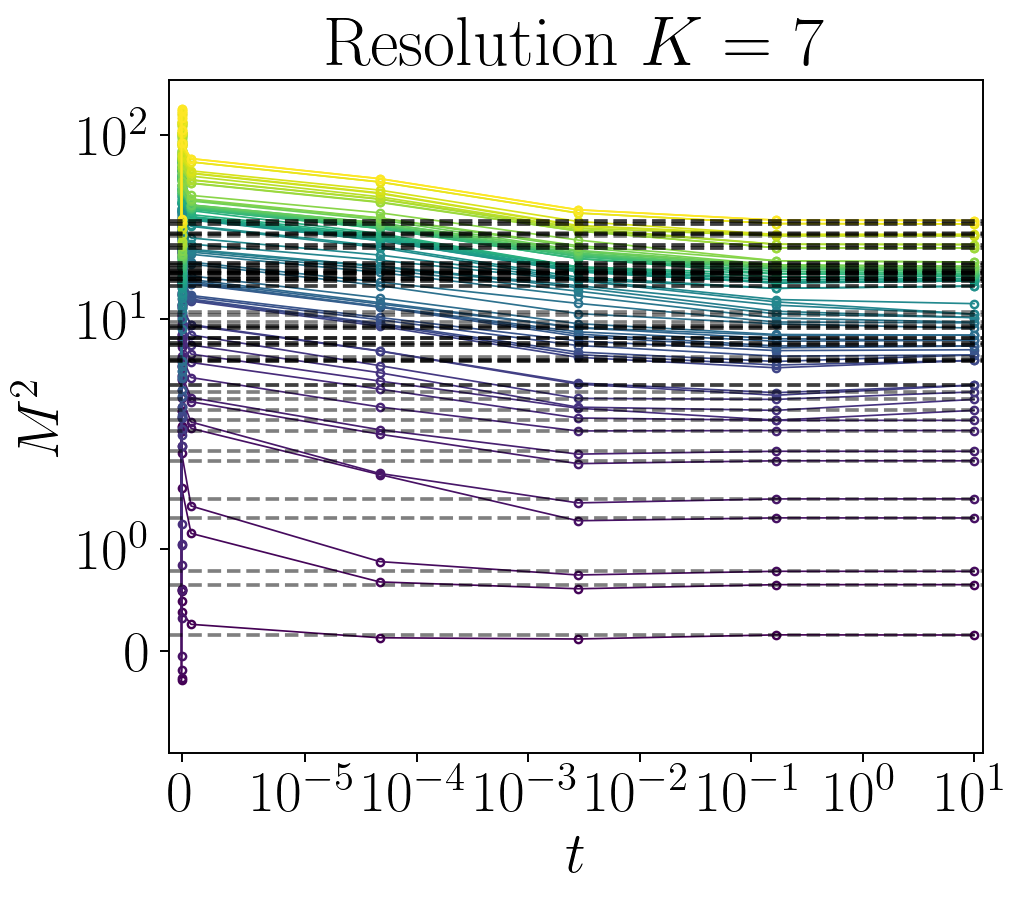

In [116]:
plt.figure(figsize = (6,5), dpi = 175)
colors = plt.cm.viridis(np.linspace(0, 1, len(shaped_eigs)))
for eigval in range(len(shaped_eigs)):
        plt.plot(ts, shaped_eigs[eigval], color = colors[eigval], linewidth = 0.7, marker = '.', markerfacecolor = 'none')

for free_val in np.hstack(get_eigenstates([max_res], g = 0, mf = mf, mb = mb, Q = Q, num_eigenstates = num_eigenstates,
                                n_particles = n_particles)[0]):
        plt.axhline(y=free_val, color='k', linestyle='--', alpha=0.5, xmin=0)
plt.ylabel(f'$M^2$')
plt.xlabel(f'$t$')
# plt.xscale('symlog', linthresh=min(ts[ts > 0]))
plt.xscale('symlog', linthresh=1e-5)

plt.xlim(-1e-6, 12)
plt.ylim(-1, 200)
plt.yscale('symlog')
plt.xticks([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
plt.title(f"Resolution $K = {max_res}$")
plt.show()



In [4]:
max_res = 7
mf = 1
mb = 0.4
g = 1
t = 1e-1
Q = 0
n_particles = 4
num_eigenstates = 'all'

resolutions = [max_res]
# resolutions = np.arange(2, max_res, 1)
renormalized_eigenvalues, renormalized_eigenvectors = get_renormalized_eigenstates(resolutions, t = t, g = g, mf = mf, 
                                                                                   mb = mb, Q = Q, num_eigenstates = num_eigenstates, n_particles = n_particles, verbose = True)

---K =  7 ---
Time of renormalized_yukawa_second_order_form_factor: 10.276238679885864
Time of boson_exchange: 3.8366219997406006
Time of fermion_exchange: 19.508336067199707
Time of fermion_self_energy (with loop): 0.0032813549041748047
Time of antifermion_self_energy (with loop): 0.002660036087036133
Time of boson_self_energy (with loop): 0.0016689300537109375
Size of Hamiltonian: 3092
Hamiltonian generated in: 33.94277906417847
Basis generated in: 0.0011670589447021484
Generating 69 x 69 Matrix...
Matrix generated in: 6.144876003265381
Calculating eigenvalues...
Eigenvalues calculated in: 0.0008649826049804688


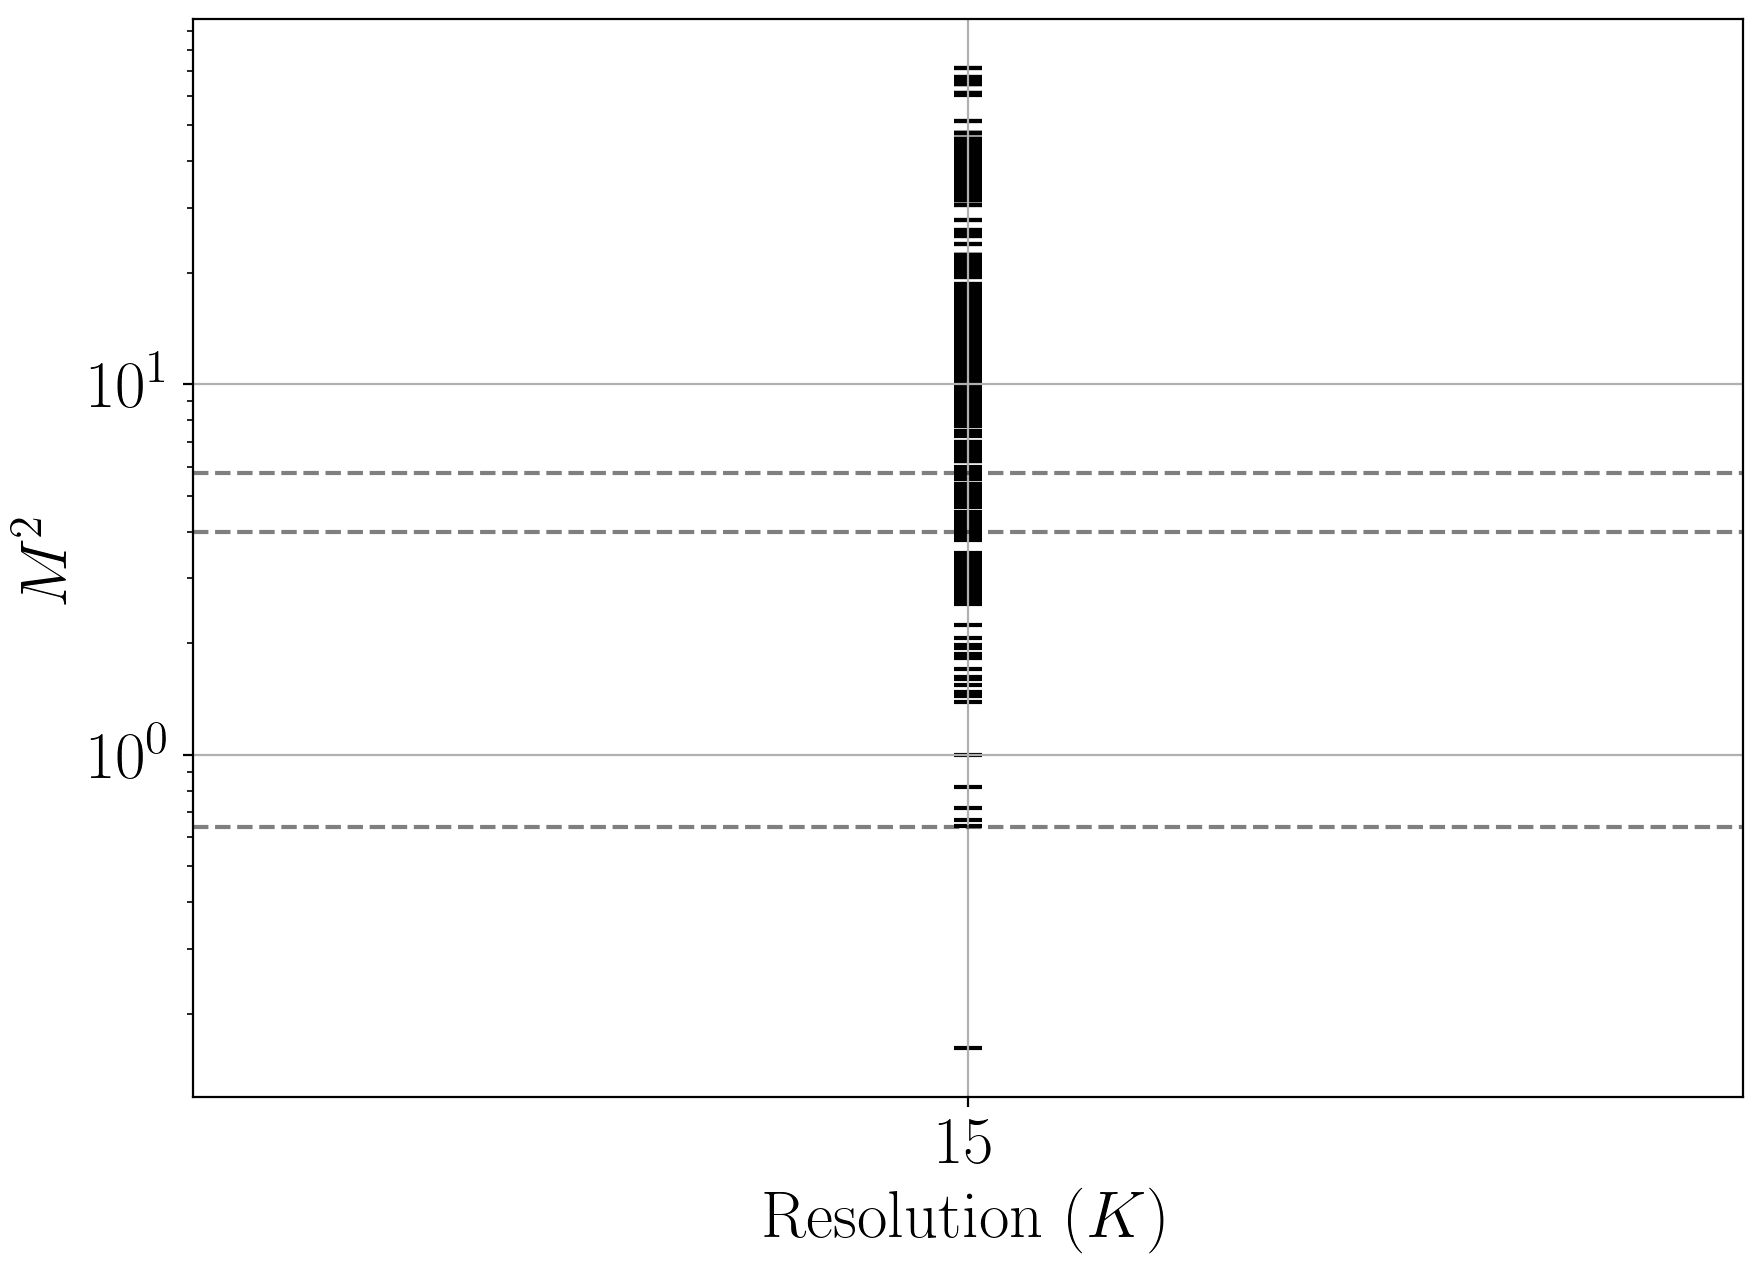

In [16]:
# eigenstate_of_interest = 12

plt.figure(figsize = (10, 7), dpi = 200)
colors = plt.cm.viridis(np.linspace(0, 1, renormalized_eigenvalues.shape[0]))
for i, eig in enumerate(renormalized_eigenvalues):
    # plt.scatter(resolutions, np.sqrt(eig),  color = colors[i], marker = '_', s = 100, label=rf"$E_{{{i}}}$")#
    # if i == eigenstate_of_interest:
    #     plt.scatter(resolutions, (eig), color = 'red', marker='_', s = 100, label = f'Eigenstate {i}')
    # else:
    plt.scatter(resolutions, (eig), color = 'black', marker='_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M^2$")
plt.axhline(y = 4*mf**2, color = 'k', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 4*mb**2, color = 'k', linestyle = '--', alpha = 0.5)
plt.axhline(y = (2*mf + mb)**2, color = 'k', linestyle = '--', alpha = 0.5) 
# plt.title( f'$t = {t}$,$g = {g}$, $m_f$ = {mf}, $m_b$ = {mb}')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
#           fancybox=True, shadow=True, ncol=np.ceil(len(renormalized_eigenvalues)/6))
plt.yscale('log')
plt.xticks(resolutions)
plt.grid()
# plt.savefig("../renormalized_spectrum.pdf", dpi=300)

In [ ]:
plt.figure(figsize = (10, 7), dpi = 200)
for res in np.arange(2, 8, 1):
    bare = yukawa_Hamiltonian(res = res, g = 1, mf = 1, mb = 1)
    ren = renormalized_Yukawa_hamiltonian(res = res, t = 1e-2, treg = 0, g = 1, mf = 1, mb = 1)
    if res == 2:
        plt.scatter(res, len(bare), color = 'blue', marker = 'o', label = 'Bare Hamiltonian')
        plt.scatter(res, len(ren), color = 'black', marker = 'o', label = 'Renormalized Hamiltonian')
    else:
        plt.scatter(res, len(bare), color = 'blue', marker = 'o')
        plt.scatter(res, len(ren), color = 'black', marker = 'o')

plt.xlabel("Resolution ($K$)")
plt.ylabel("Number of terms in Hamiltonian")
plt.yscale('log')
plt.legend()
plt.savefig('../n_terms.pdf')

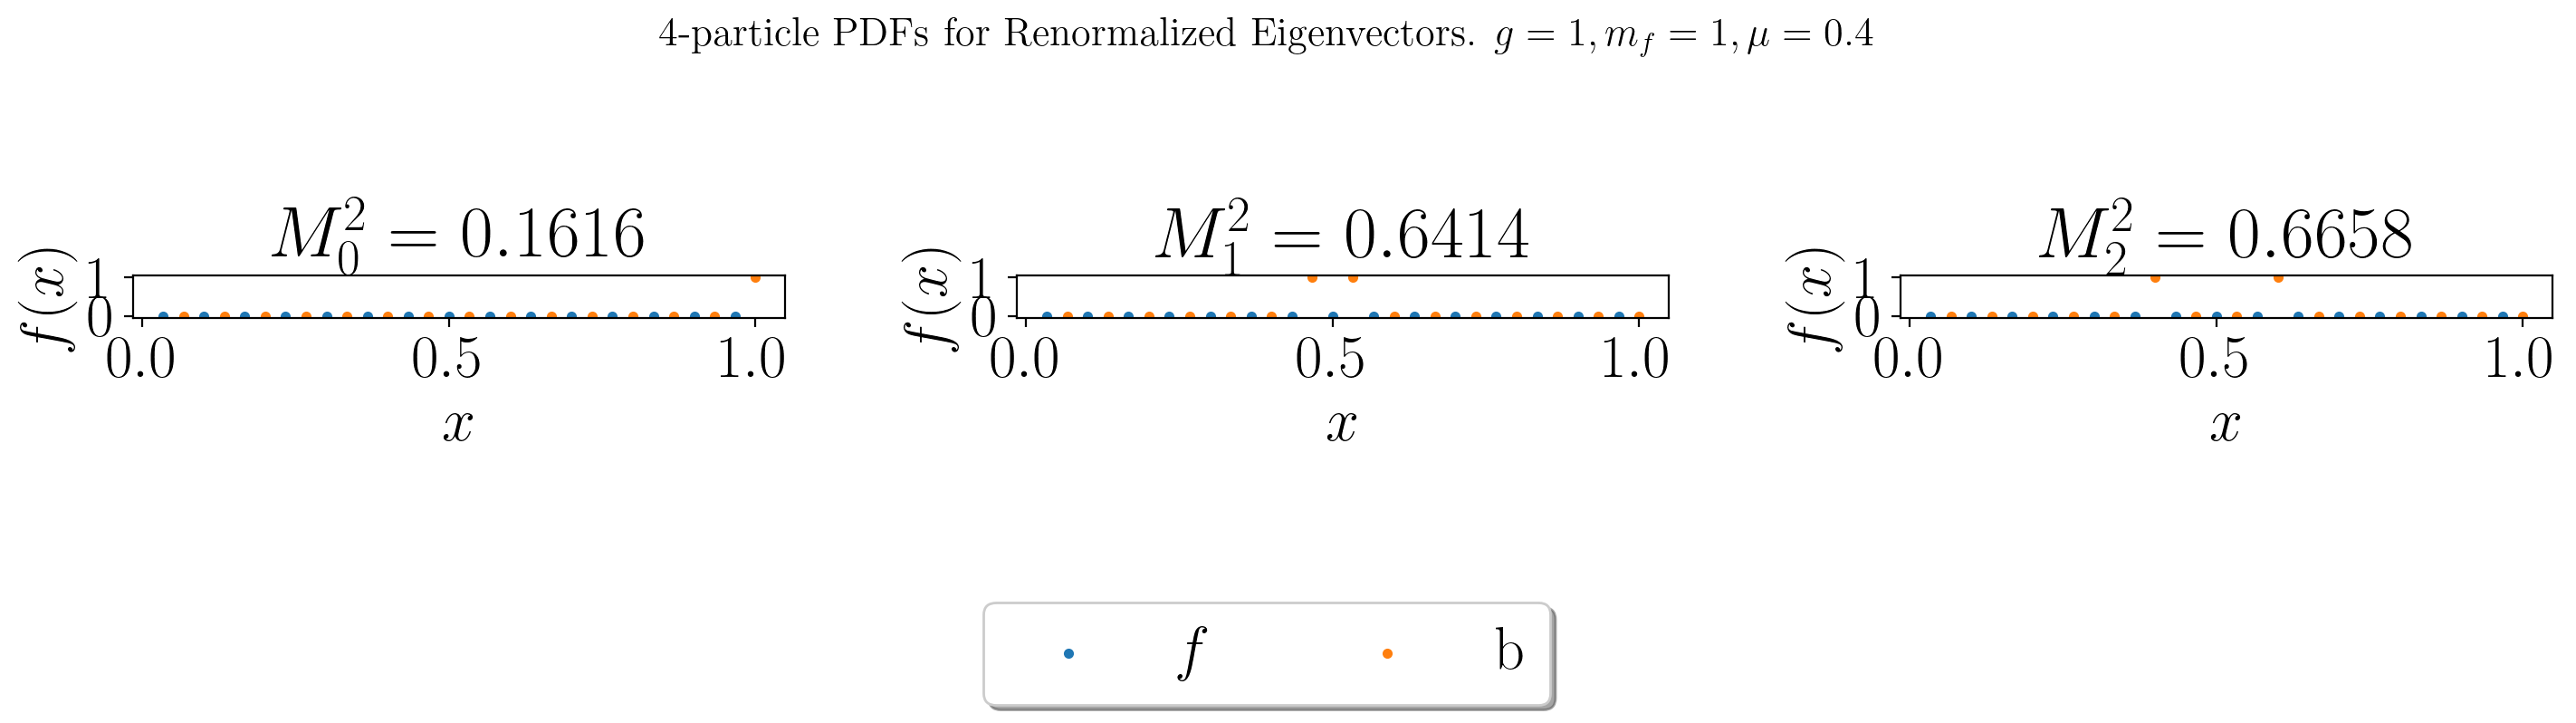

In [17]:
# num_eigenvectors = len(renormalized_eigenvectors)
num_eigenvectors = 3

cols = 3
rows = (num_eigenvectors + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), dpi=200)
axes = axes.flatten()

handles, labels = [], []
res = max_res
for idx, ax in enumerate(axes):
    if idx < num_eigenvectors:
        psi = renormalized_eigenvectors[idx]
        fermion_pdf = pdf(res, psi, 'fermion')
        antifermion_pdf = pdf(res, psi, 'antifermion')
        boson_pdf = pdf(res, psi, 'boson')

        x_fermion = np.array([k / res for k in np.arange(1 / 2, res, 1)])
        x_boson = np.array([k / res for k in np.arange(1, res + 1, 1)])

    
        scatter_fermion = ax.scatter(x_fermion, np.real(fermion_pdf), marker='.', label='$f$')

        if idx == 0:
            handles.extend([scatter_fermion])
            labels.extend(['$f$'])

        scatter_boson = ax.scatter(x_boson, np.real(boson_pdf), marker='.', label='$b$')
        if idx == 0:
            handles.append(scatter_boson)
            labels.append('b')

        ax.set_xlabel('$x$')
        ax.set_ylabel('$f(x)$')
        # ax.set_yscale('log')
        ax.set_title(f"$M_{{{idx}}}^2 = {round(renormalized_eigenvalues[idx][0], 4)}$")
    else:
        ax.axis('off') 

fig.suptitle(f"{n_particles}-particle PDFs for Renormalized Eigenvectors. $g = {g}, m_f = {mf}, \mu = {mb}$", fontsize=16, y = 1.02)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=len(labels))



plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

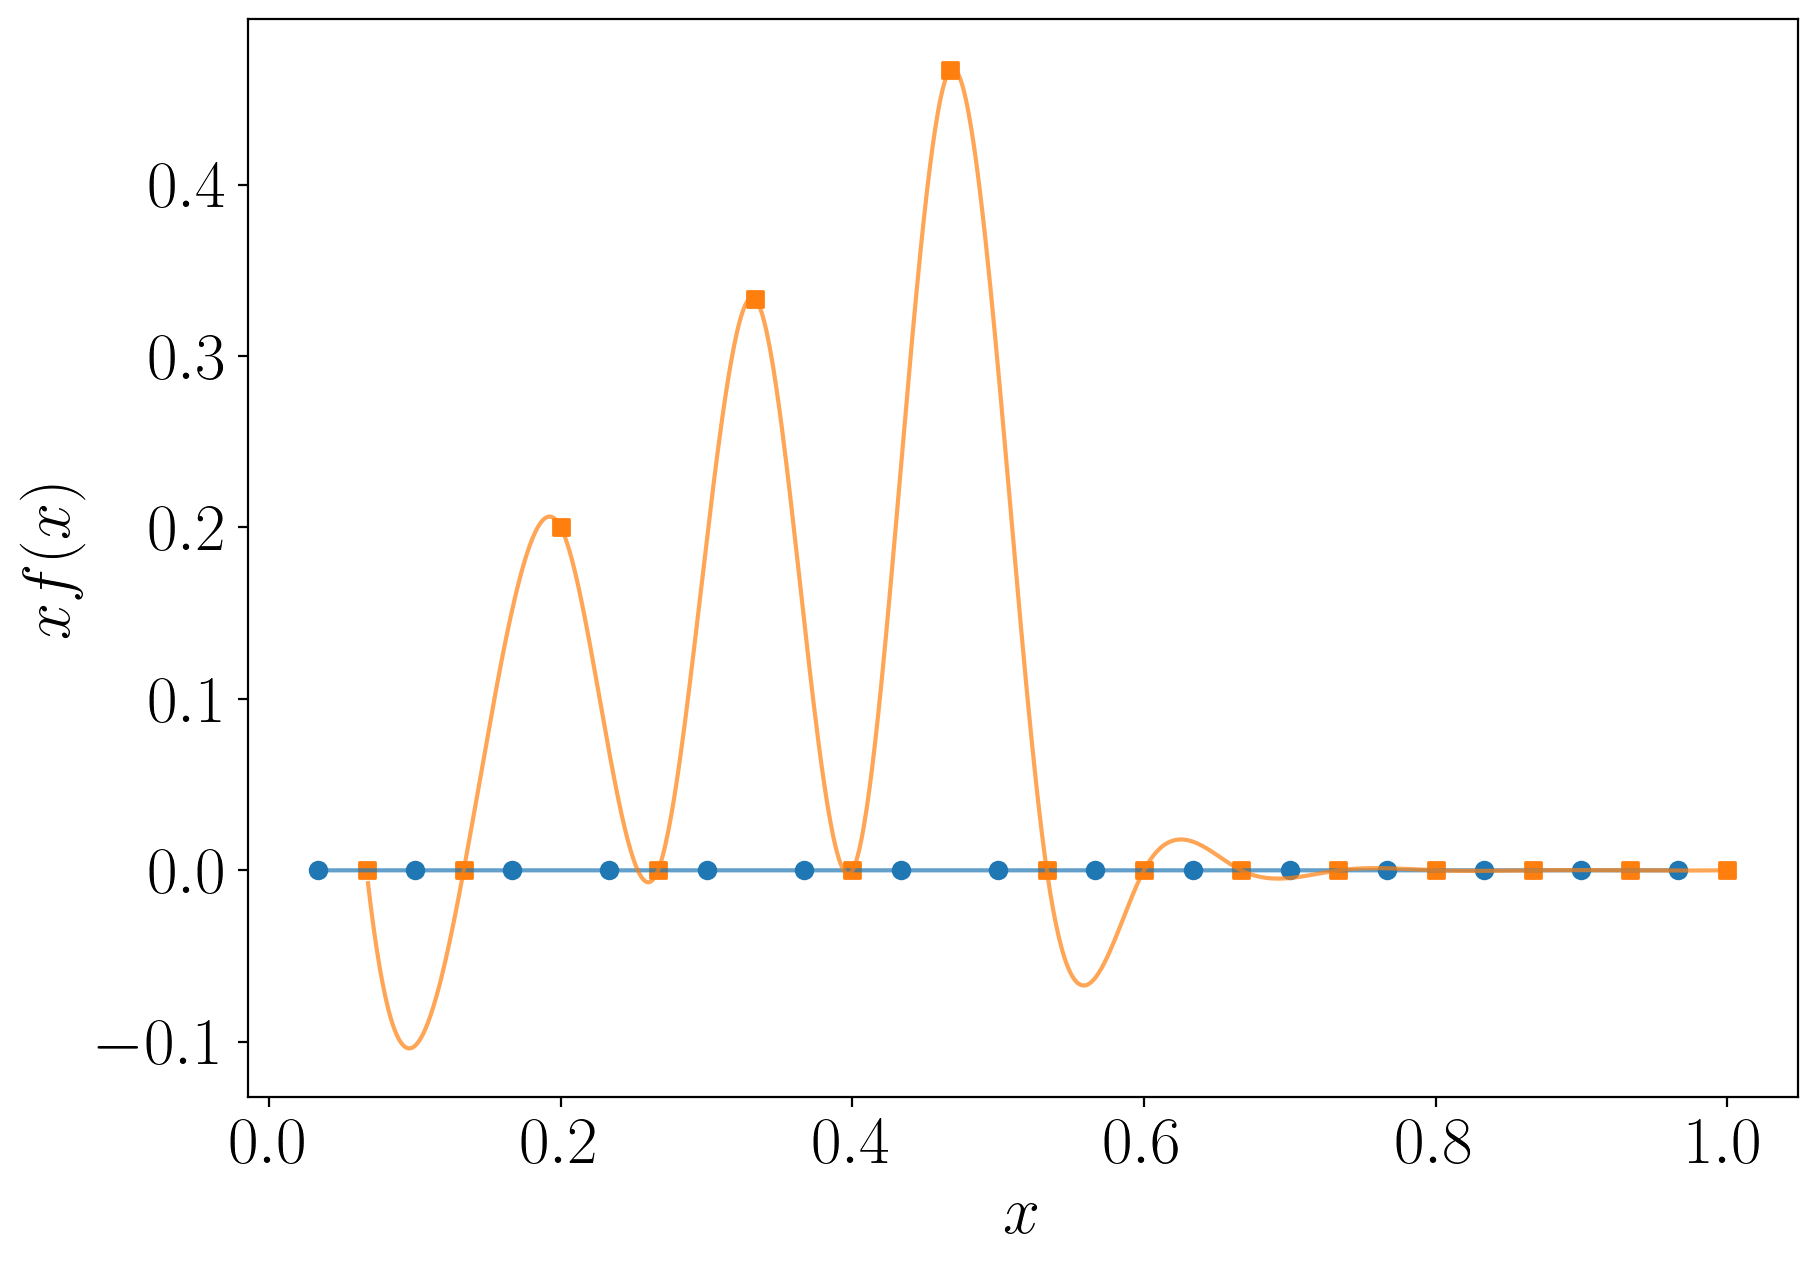

In [14]:
psi = renormalized_eigenvectors[11]
res = max_res

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
fermion_pdf = x_fermion* np.real(pdf(res, psi, 'fermion'))

x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])
boson_pdf = x_boson * np.real(pdf(res, psi, 'boson'))

dx = 0.001
degree = 3

smooth_x_range_fermion = np.arange(min(x_fermion) + dx, max(x_fermion) - dx, dx)
smooth_x_range_boson = np.arange(min(x_boson) + dx, max(x_boson) - dx, dx)

interp_func_fermion = CubicSpline(x_fermion, fermion_pdf)
interp_func_boson = CubicSpline(x_boson, boson_pdf)

smooth_fermion_pdf = interp_func_fermion(smooth_x_range_fermion)
smooth_boson_pdf = interp_func_boson(smooth_x_range_boson)

plt.figure(figsize = (10,7), dpi = 200)


plt.scatter(x_fermion, fermion_pdf, marker = 'o', label = f'$f$')
plt.plot(smooth_x_range_fermion, smooth_fermion_pdf, alpha = 0.7)

plt.scatter(x_boson, boson_pdf, marker = 's', label = f'$b$')
plt.plot(smooth_x_range_boson, smooth_boson_pdf, alpha = 0.7)
plt.plot([], [], color = 'white', label = f"$M^2 = {round(renormalized_eigenvalues[11][0], 3)}$")

# plt.scatter([], [], color = 'white', label = f'{max_weight}')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#           fancybox=True, shadow=True, ncol=3)
# plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
plt.savefig("../pdf.pdf")
# plt.ylim(-0.1, 1.1)
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")
# plt.title(f"$g = {g}, m = {mf}, \mu = {mb}$")